In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

file_path = 'data.csv'

data = pd.read_csv(file_path)

# data["sex"].replace(['male', 'female'], [0, 1], inplace=True)
# data["smoker"].replace(['no', 'yes'], [0, 1],  inplace=True)
# data_model = data.drop("region", axis=1)
# print(data_model)

# region_dummies = pd.get_dummies(data['region'], prefix='is', prefix_sep='_')


# # Concaténer les colonnes binaires avec le DataFrame original
# data = pd.concat([data, region_dummies], axis=1)
# data = data.drop(['region'], axis=1)

# Vérification des informations manquantes et des doublons
missing_data = data.isnull().sum()
duplicates = data.duplicated().sum()
data = data.drop_duplicates()


# Afficher le DataFrame avec les nouvelles colonnes binaires
print(data.head())


   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520


In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


data.dropna(axis=0, inplace=True)


X = data.drop('charges', axis=1)
y = data['charges']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, train_size=0.85, random_state=42, stratify=X['smoker'])
# 80% pour train et 20% de test

print("Train set X", X_train.shape)
print("Train set Y", y_train.shape)
print("Test set X", X_test.shape)
print("Test set Y", y_test.shape)



Train set X (1136, 6)
Train set Y (1136,)
Test set X (201, 6)
Test set Y (201,)


In [27]:

# Identifier les colonnes catégories et numériques
numerical_cols = X.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X.select_dtypes(include=['object']).columns


# Créer le pipeline pour les features numériques
numerical_pipeline = Pipeline([
    ('scaler', StandardScaler())
])

# Créer le pipeline pour les features catégoriales
categorial_pipeline = Pipeline([
    ('encoder', OneHotEncoder())
])

# Combine les pipelines en utilisant ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('numerical', numerical_pipeline, numerical_cols),
        ('categorial', categorial_pipeline, categorical_cols)
    ])




# Créer le pipeline final en ajoutant le model

LR_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regression', LinearRegression())
])

Lasso_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('Lasso', Lasso())
])

ElasticNet_pipeline = Pipeline([
    ('prepocessor', preprocessor),
    ('ElasticNet', ElasticNet())
])


# On entraine les donnnées
LR_pipeline.fit(X_train, y_train)
Lasso_pipeline.fit(X_train, y_train)
ElasticNet_pipeline.fit(X_train, y_train)





ColumnTransformer(transformers=[('numerical',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 Index(['age', 'bmi', 'children'], dtype='object')),
                                ('categorial',
                                 Pipeline(steps=[('encoder', OneHotEncoder())]),
                                 Index(['sex', 'smoker', 'region'], dtype='object'))])


In [21]:
# On predicte
y_pred_EN = ElasticNet_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_EN)
r2 = r2_score(y_test, y_pred_EN)
rmse = np.sqrt(mse)
print(f" score du ELASTICNET modèle : {ElasticNet_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

 score du ELASTICNET modèle : 0.5628147050611061
mse : 63355051.802986965
r2 : 0.5628147050611061
rmse : 7959.588670464509


In [22]:
# On predicte
y_pred_LR = LR_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_LR)
r2 = r2_score(y_test, y_pred_LR)
rmse = np.sqrt(mse)
print(f" score du LR modèle : {LR_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

 score du LR modèle : 0.8265441393970117
mse : 25136492.83553786
r2 : 0.8265441393970117
rmse : 5013.630703944783


In [23]:
# On predicte
y_pred_Lasso = Lasso_pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred_Lasso)
r2 = r2_score(y_test, y_pred_Lasso)
rmse = np.sqrt(mse)
print(f" score du Lasso modèle : {Lasso_pipeline.score(X_test, y_test)}")
print(f"mse : {mse}")
print(f"r2 : {r2}")
print(f"rmse : {rmse}")

 score du Lasso modèle : 0.8265828252204989
mse : 25130886.648917574
r2 : 0.8265828252204989
rmse : 5013.071578275895


In [24]:
X_Subject_lasso = pd.DataFrame({
    'age': [28],
    'sex': [0],
    'bmi': [26],
    'children': [0],
    'smoker': [0],
    'is_northeast': [1],
    'is_northwest': [0],
    'is_southeast': [0],
    'is_southwest': [0]
})

y_subject = Lasso_pipeline.predict(X_Subject_lasso)
print("Avec mes données, je payerai:", y_subject)

KeyError: "['region'] not in index"

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = { 'ElasticNet__alpha': [0.1,0.5,1.0,5.0,10.0],
               'ElasticNet__l1_ratio': [0.1,0.3,0.5,0.7,0.9]
              }

grid = GridSearchCV(ElasticNet_pipeline, param_grid, cv= 5)

grid.fit(X_train, y_train)
grid.best_params_


{'ElasticNet__alpha': 0.1, 'ElasticNet__l1_ratio': 0.9}

In [ ]:
model = grid.best_estimator_

In [ ]:
model.score(X_test, y_test)

0.8259549821131773

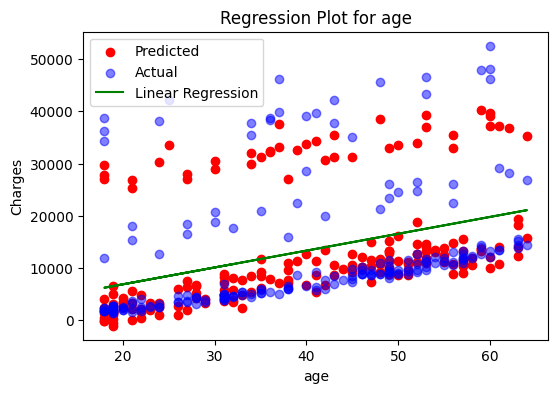

ValueError: could not convert string to float: 'female'

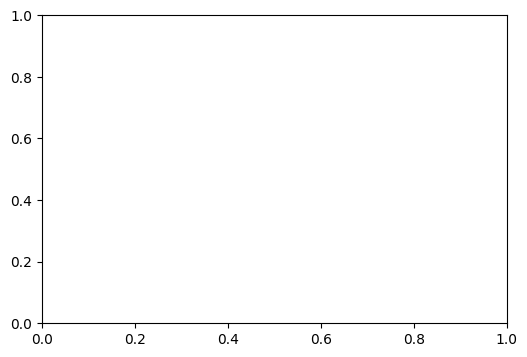

In [ ]:
from sklearn.linear_model import LinearRegression

# Créer une régression linéaire
regression = LinearRegression()

# Parcourir chaque colonne de X
for col in X_test.columns:
    # Créer une figure et un axe pour chaque colonne
    fig, ax = plt.subplots(figsize=(6, 4))
    
    # Fit de la régression linéaire sur la colonne actuelle et les valeurs prédites
    regression.fit(X_test[[col]], y_pred_Lasso)
    
    # Tracer les valeurs prédites en fonction de la colonne actuelle
    ax.scatter(X_test[col], y_pred_Lasso, color='red', label='Predicted')
    
    # Tracer les valeurs réelles en fonction de la colonne actuelle
    ax.scatter(X_test[col], y_test, color='blue', alpha=0.5, label='Actual')
    
    # Tracer la ligne de régression linéaire pour la colonne actuelle
    ax.plot(X_test[col], regression.predict(X_test[[col]]), color='green', label='Linear Regression')
    
    # Ajouter des étiquettes et une légende pour la colonne actuelle
    ax.set_xlabel(col)
    ax.set_ylabel('Charges')
    ax.legend()
    
    # Afficher le titre basé sur la colonne
    ax.set_title(f'Regression Plot for {col}')
    
    # Afficher le graphique pour la colonne actuelle
    plt.show()
